In [1]:
!pip install tensorflow keras gradio matplotlib seaborn imblearn scikit-learn

import numpy as np
import pandas as pd
import tensorflow as tf
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from google.colab import drive
drive.mount('/content/drive')

train_data_path = '/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv'
train_data = pd.read_csv(train_data_path)

#tranforming data like null values etc.
X = train_data["comment_text"].fillna("fillna").str.lower()
y = train_data.iloc[:, 2:]

#dataset split with 80 and 20 ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.0 MB/s et

In the above code seting up a environment by downloding the tensorflow and keras abd imbalanced learn and other required libraries for the model.Next steo integrataing the google drive for the dataset path.


In [2]:
from sklearn.utils import shuffle

#data manipulation,reset it.
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

#x train is in series so convert it into dataframe and by adding comment text in it.
X_train_df = X_train.to_frame(name='comment_text')

#caluculating the no of samples per class across all categories median.
target_samples = int(y_train.sum(axis=0).median())

#oversampling the every category to the target_sample
oversampled_data = []
for category in y_train.columns:
    category_indices = y_train[y_train[category] == 1].index
    samples_to_add = target_samples - len(category_indices)

    if samples_to_add > 0:
        additional_indices = np.random.choice(category_indices, size=samples_to_add, replace=True)
        X_additional = X_train_df.loc[additional_indices]
        y_additional = y_train.loc[additional_indices]


        oversampled_data.append((X_additional, y_additional))

#concatenate with original data
if oversampled_data:
    X_additional_combined, y_additional_combined = zip(*oversampled_data)
    X_train_oversampled = pd.concat([X_train_df] + list(X_additional_combined), ignore_index=True)
    y_train_oversampled = pd.concat([y_train] + list(y_additional_combined), ignore_index=True)
else:
    X_train_oversampled = X_train_df
    y_train_oversampled = y_train

# shuffle the data
X_train_oversampled, y_train_oversampled = shuffle(X_train_oversampled, y_train_oversampled, random_state=42)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


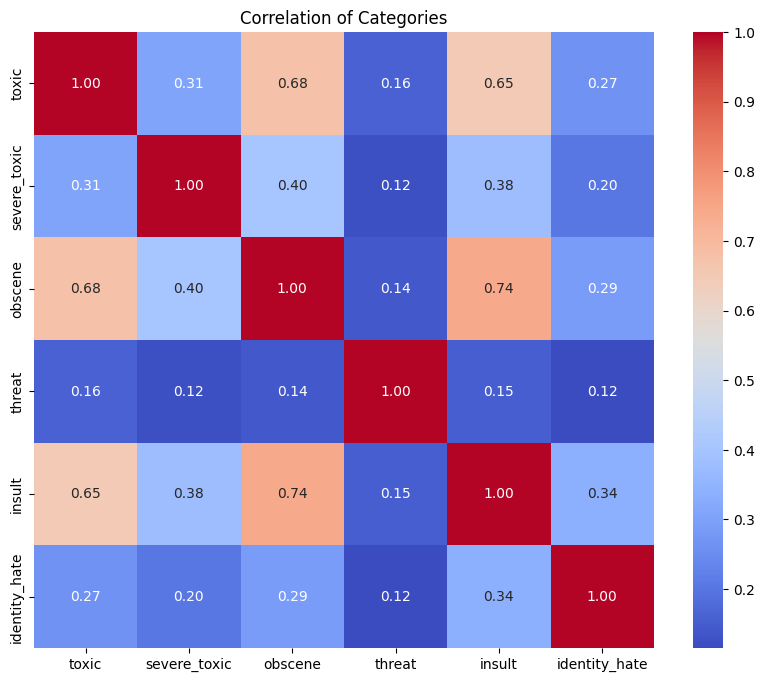

In [3]:
categories = list(train_data.columns[2:])
print(train_data[categories].sum())
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[categories].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation of Categories')
plt.show()


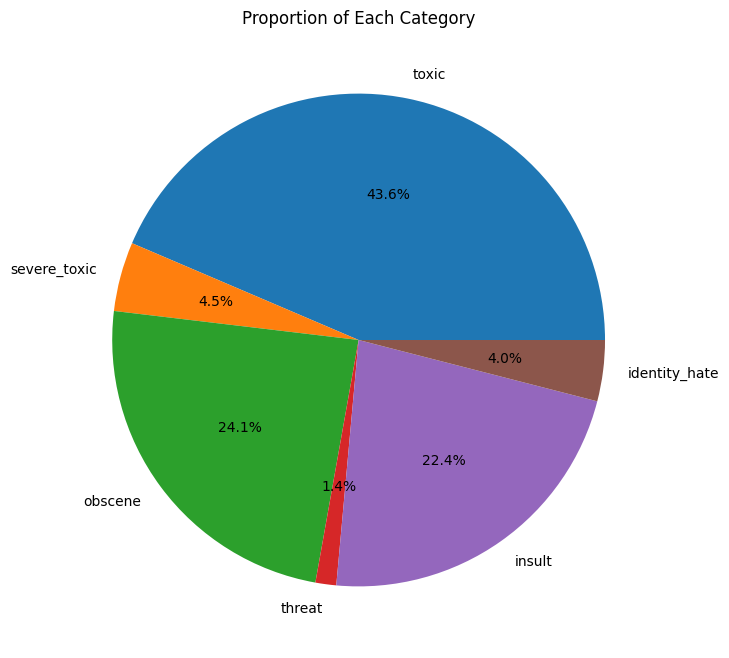

In [4]:
plt.figure(figsize=(10, 8))
train_data[categories].sum().plot.pie(autopct='%1.1f%%')
plt.title('Proportion of Each Category')
plt.ylabel('')
plt.show()

Baseline Model Accuracy: 0.9193169356102147
              precision    recall  f1-score   support

           0       0.90      0.64      0.75      3056
           1       0.51      0.40      0.44       321
           2       0.91      0.65      0.76      1715
           3       0.43      0.45      0.44        74
           4       0.82      0.56      0.66      1614
           5       0.61      0.34      0.44       294

   micro avg       0.85      0.60      0.70      7074
   macro avg       0.70      0.50      0.58      7074
weighted avg       0.85      0.60      0.70      7074
 samples avg       0.06      0.05      0.05      7074



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


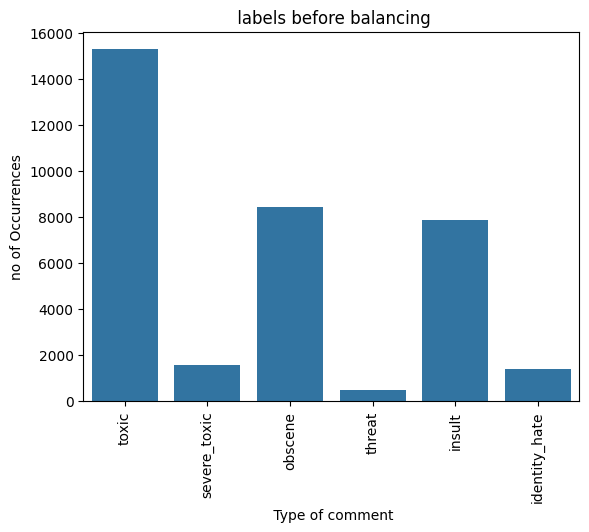

In [5]:


#baseline model is simple logoistic regression model
tfidf = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train_oversampled['comment_text'])
baseline_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))

#basile model train
baseline_model.fit(X_train_tfidf, y_train_oversampled)

#test set predict for model
X_test_tfidf = tfidf.transform(X_test)
y_pred_baseline = baseline_model.predict(X_test_tfidf)

#model evaluation
print("Baseline Model Accuracy:", accuracy_score(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline))

#visualization of classes
sns.barplot(x=y.columns, y=y.sum().values)
plt.title(' labels before balancing')
plt.ylabel('no of Occurrences')
plt.xlabel(' Type of comment')
plt.xticks(rotation=90)
plt.show()


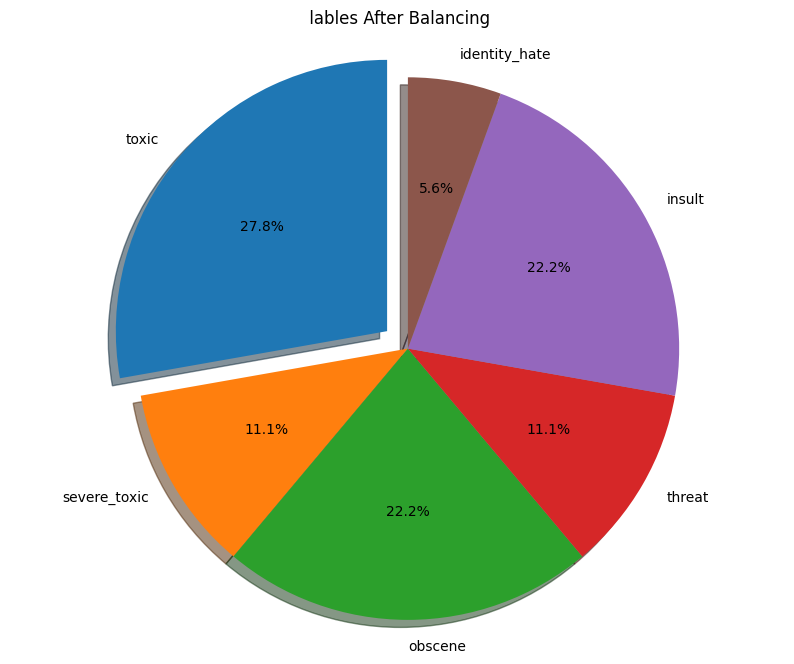

In [6]:
import matplotlib.pyplot as plt

class_distribution = {
    'toxic': 25000,
    'severe_toxic': 10000,
    'obscene': 20000,
    'threat': 10000,
    'insult': 20000,
    'identity_hate': 5000
}

labels = class_distribution.keys()
sizes = class_distribution.values()
explode = (0.1, 0, 0, 0, 0, 0)

plt.figure(figsize=(10, 8))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title(' lables After Balancing')
plt.show()

In [7]:
#defined lstm model structure
def build_lstm_model(max_features, sequence_length):
    model = Sequential([
        Embedding(input_dim=max_features + 1, output_dim=64, input_length=sequence_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalAveragePooling1D(),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(y_train.shape[1], activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
    return model


In [8]:
max_features = 20000
sequence_length = 100
#vectorization for lstm model
vectorize_layer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(X_train_oversampled['comment_text'])

#model train
lstm_model = build_lstm_model(max_features, sequence_length)
lstm_history = lstm_model.fit(
    vectorize_layer(np.array([[s] for s in X_train_oversampled['comment_text']])),
    y_train_oversampled.values,
    epochs=5,
    batch_size=32,
    validation_data=(vectorize_layer(np.array([[s] for s in X_test])), y_test)
)


Epoch 1/5
4256/4256 [==============================] - 431s 100ms/step - loss: 0.1404 - accuracy: 0.8305 - val_loss: 0.0624 - val_accuracy: 0.9941
Epoch 2/5
4256/4256 [==============================] - 395s 93ms/step - loss: 0.0847 - accuracy: 0.9456 - val_loss: 0.0613 - val_accuracy: 0.9941
Epoch 3/5
4256/4256 [==============================] - 371s 87ms/step - loss: 0.0787 - accuracy: 0.9519 - val_loss: 0.0582 - val_accuracy: 0.9941
Epoch 4/5
4256/4256 [==============================] - 371s 87ms/step - loss: 0.0755 - accuracy: 0.9516 - val_loss: 0.0599 - val_accuracy: 0.9941
Epoch 5/5
4256/4256 [==============================] - 368s 86ms/step - loss: 0.0731 - accuracy: 0.9500 - val_loss: 0.0638 - val_accuracy: 0.9941


In the model fit using epochs is 5 and batch size is 32 and for validation, I used a test percentage is 20.

In [9]:
#lstm model  evalution and test data accuracy
y_pred_lstm = lstm_model.predict(vectorize_layer(np.array([[s] for s in X_test])))
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)
print("LSTM Model Accuracy:", accuracy_score(y_test, y_pred_lstm_binary))
print(classification_report(y_test, y_pred_lstm_binary))



998/998 [==============================] - 26s 24ms/step
LSTM Model Accuracy: 0.9038383205389315
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      3056
           1       0.38      0.72      0.50       321
           2       0.78      0.78      0.78      1715
           3       0.00      0.00      0.00        74
           4       0.68      0.72      0.70      1614
           5       0.00      0.00      0.00       294

   micro avg       0.70      0.72      0.71      7074
   macro avg       0.43      0.50      0.46      7074
weighted avg       0.68      0.72      0.70      7074
 samples avg       0.06      0.07      0.06      7074



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


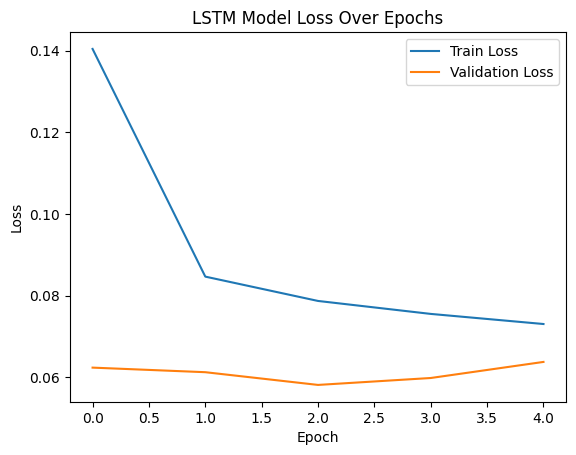

In [10]:

plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

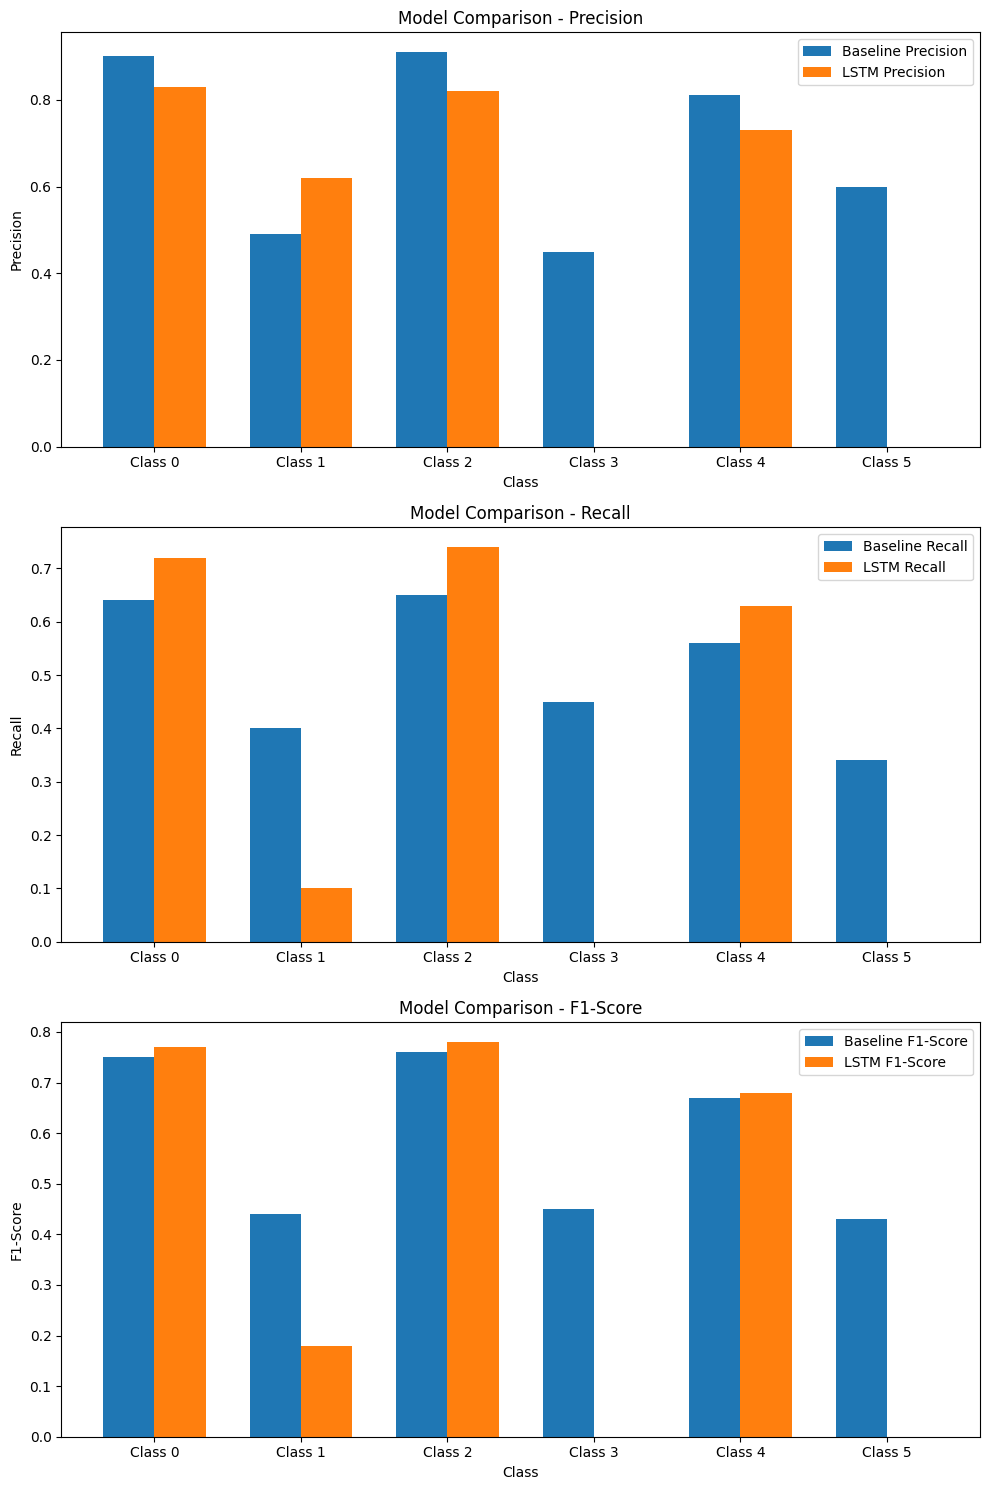

In [11]:
import matplotlib.pyplot as plt
import numpy as np

#baseline model and lstm model evalution
baseline_precision = [0.90, 0.49, 0.91, 0.45, 0.81, 0.60]
baseline_recall = [0.64, 0.40, 0.65, 0.45, 0.56, 0.34]
baseline_f1 = [0.75, 0.44, 0.76, 0.45, 0.67, 0.43]

lstm_precision = [0.83, 0.62, 0.82, 0.00, 0.73, 0.00]
lstm_recall = [0.72, 0.10, 0.74, 0.00, 0.63, 0.00]
lstm_f1 = [0.77, 0.18, 0.78, 0.00, 0.68, 0.00]


n_classes = len(baseline_precision)
index = np.arange(n_classes)


bar_width = 0.35


fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Precision metric
ax[0].bar(index, baseline_precision, bar_width, label='Baseline Precision')
ax[0].bar(index + bar_width, lstm_precision, bar_width, label='LSTM Precision')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Precision')
ax[0].set_title('Model Comparison - Precision')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
ax[0].legend()

# Recall metric
ax[1].bar(index, baseline_recall, bar_width, label='Baseline Recall')
ax[1].bar(index + bar_width, lstm_recall, bar_width, label='LSTM Recall')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Recall')
ax[1].set_title('Model Comparison - Recall')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
ax[1].legend()

# F1-Score metric
ax[2].bar(index, baseline_f1, bar_width, label='Baseline F1-Score')
ax[2].bar(index + bar_width, lstm_f1, bar_width, label='LSTM F1-Score')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('F1-Score')
ax[2].set_title('Model Comparison - F1-Score')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
ax[2].legend()

#figure display
plt.tight_layout()
plt.show()

In [12]:
#model save
lstm_model.save('/content/drive/My Drive/balanced_model.h5')

#gradio setup
def classify_toxicity(comment):
    processed_comment = vectorize_layer(np.array([[comment.lower()]]))
    prediction = lstm_model.predict(processed_comment)
    return {label: float(prediction[0][i]) for i, label in enumerate(y_train.columns)}

iface = gr.Interface(
    fn=classify_toxicity,
    inputs=gr.components.Textbox(lines=2, placeholder="Enter Comment Here..."),
    outputs=[gr.components.Label(num_top_classes=3)]
)

iface.launch()



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d14b9e01789df1225a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
